# Testing All Models
In this notebook we will test all machine learning and deep learning models.

In [1]:
from testing_models import evaluate_model, test_model_nn
from preprocess import get_data
from classifiers import *
from nn import *
from torch import *

## Data
We used data from the Alpha_Num dataset on kaggle. It contains over 108000 images of handwritten characters. Each image is approximately 28x28 pixels and is in gray-scale. However, before we can train the models we preprocessed them to ensure each image had the same features:
* 28x28 pixels: any image less than 28x28 was padded
* Gray-Scale

In [2]:
X_train, y_train = get_data("train", "ascii_file_counts.csv")
X_test, y_test = get_data("test", "ascii_file_counts.csv")

## Machine Learning Models
In this section we will run and test the following models:
* XGBoost
* Random Forest
* Perceptron
* Support Vector Machine
* K-Nearest Neighbors

For more information please refer to the **classifiers.py** 

In [ ]:
# XGboost train
estimators = range(20,100, 10)
depths = range(2,20,2)

f1_list_estimators = []
acc_list_estimators = []
prec_list_estimators =[]
recall_list_estimators = []

for estimator_count in estimators:
   model = train_xgboost(X_train, y_train, n_estimators = estimator_count, max_depth = 10)
   y_pred = model.predict(X_test)
   f1, acc, cm, prec, recall = evaluate_model(model, y_test, y_pred)
   f1_list_estimators.append(f1)
   acc_list_estimators.append(acc)
   prec_list_estimators.append(prec)
   recall_list_estimators.append(recall)

f1_list_depth = []
acc_list_depth = []
prec_list_depth =[]
recall_list_depth = []

for depth in depths:
   model = train_xgboost(X_train, y_train, n_estimators =35, max_depth = depth)
   y_pred = model.predict(X_test)
   f1, acc, cm, prec, recall = evaluate_model(model, y_test, y_pred)
   f1_list_depth.append(f1)
   acc_list_depth.append(acc)
   prec_list_depth.append(prec)
   recall_list_depth.append(recall)


In [ ]:
# Create Plots
XGBoost_Estimators_Plots(estimators, f1_list_estimators, acc_list_estimators, prec_list_estimators, recall_list_estimators)
XGBoost_Depth_Plots(depth, f1_list_depth, acc_list_depth, prec_list_depth, recall_list_depth)
  

In [ ]:
# Random Forest Train
estimators = range(20,100, 10)

f1_list_estimators = []
acc_list_estimators = []
prec_list_estimators =[]
recall_list_estimators = []

for estimator_count in estimators:
   model = train_random_forest(X_train, y_train, n_estimators = estimator_count)
   y_pred = model.predict(X_test)
   f1, acc, cm, prec, recall = evaluate_model(model, y_test, y_pred)
   f1_list_estimators.append(f1)
   acc_list_estimators.append(acc)
   prec_list_estimators.append(prec)
   recall_list_estimators.append(recall)

In [ ]:
RandomForest_plots(depth, f1_list_estimators, acc_list_estimators, prec_list_estimators, recall_list_estimators)
   

In [ ]:
#KNN Forest Train
neighbors = range(5, 100, 5)

f1_list_neighbors = []
acc_list_neighbors = []
prec_list_neighbors =[]
recall_list_neighbors = []

for neighbor in neighbors:
   model = train_knn(X_train, y_train, n_neighbors=neighbor)
   y_pred = model.predict(X_test)
   f1, acc, cm, prec, recall = evaluate_model(model, y_test, y_pred)
   f1_list_neighbors.append(f1)
   acc_list_neighbors.append(acc)
   prec_list_neighbors.append(prec)
   recall_list_neighbors.append(recall)

In [ ]:
KNN_Plots(depth, f1_list_neighbors, acc_list_neighbors, prec_list_neighbors, recall_list_neighbors)  

In [ ]:
#SVM Train
kernels = ['poly', 'rbf', 'linear', 'sigmoid', 'precomputed']

f1_list_kernel = []
acc_list_kernel = []
prec_list_kernel =[]
recall_list_kernel = []

for kernel in kernels:
   model = train_knn(X_train, y_train, kernel = kernel)
   y_pred = model.predict(X_test)
   f1, acc, cm, prec, recall = evaluate_model(model, y_test, y_pred)
   f1_list_kernel.append(f1)
   acc_list_kernel.append(acc)
   prec_list_kernel.append(prec)
   recall_list_kernel.append(recall)


In [ ]:
SVM_plot(kernels, f1_list_kernel, acc_list_kernel, prec_list_kernel, recall_list_kernel)

In [3]:
f1_list = []
acc_list = []
prec_list = []
recall_list = []

In [4]:
test = torch.load("FeedForward.pth")
dataset_test = AlphaNumDataset(csv_dir="ascii_file_counts.csv", data_dir="test")
data_loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  
f1,acc,prec,recall =test_model_nn(test,data_loader_test, device, criterion)

/var/folders/92/3_42v5w111v7m641kr368p5c0000gn/T/ipykernel_12081/3860436462.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load("FeedForward.pth")
/opt/ana

In [5]:
f1_list.append(f1)
acc_list.append(acc)
prec_list.append(prec)
recall_list.append(recall)

In [6]:
test = torch.load("cnn.pth")
dataset_test = AlphaNumDataset(csv_dir="ascii_file_counts.csv", data_dir="test")
data_loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  
f1,acc,prec,recall = test_model_nn(test,data_loader_test, device, criterion)

/var/folders/92/3_42v5w111v7m641kr368p5c0000gn/T/ipykernel_12081/4169322587.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load("cnn.pth")
/opt/anaconda3/l

In [7]:
f1_list.append(f1)
acc_list.append(acc)
prec_list.append(prec)
recall_list.append(recall)

In [8]:
test = torch.load("cnn_lstm.pth")
dataset_test = AlphaNumDataset(csv_dir="ascii_file_counts.csv", data_dir="test")
data_loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  
f1,acc,prec,recall = test_model_nn(test,data_loader_test, device, criterion)

/var/folders/92/3_42v5w111v7m641kr368p5c0000gn/T/ipykernel_12081/2508533408.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load("cnn_lstm.pth")
/opt/anacon

In [9]:
f1_list.append(f1)
acc_list.append(acc)
prec_list.append(prec)
recall_list.append(recall)

In [10]:
test = torch.load("transformer.pth")
dataset_test = AlphaNumDataset(csv_dir="ascii_file_counts.csv", data_dir="test")
data_loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  
f1,acc,prec,recall = test_model_nn(test,data_loader_test, device, criterion)

/var/folders/92/3_42v5w111v7m641kr368p5c0000gn/T/ipykernel_12081/555459042.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load("transformer.pth")
/opt/anac

In [11]:
f1_list.append(f1)
acc_list.append(acc)
prec_list.append(prec)
recall_list.append(recall)

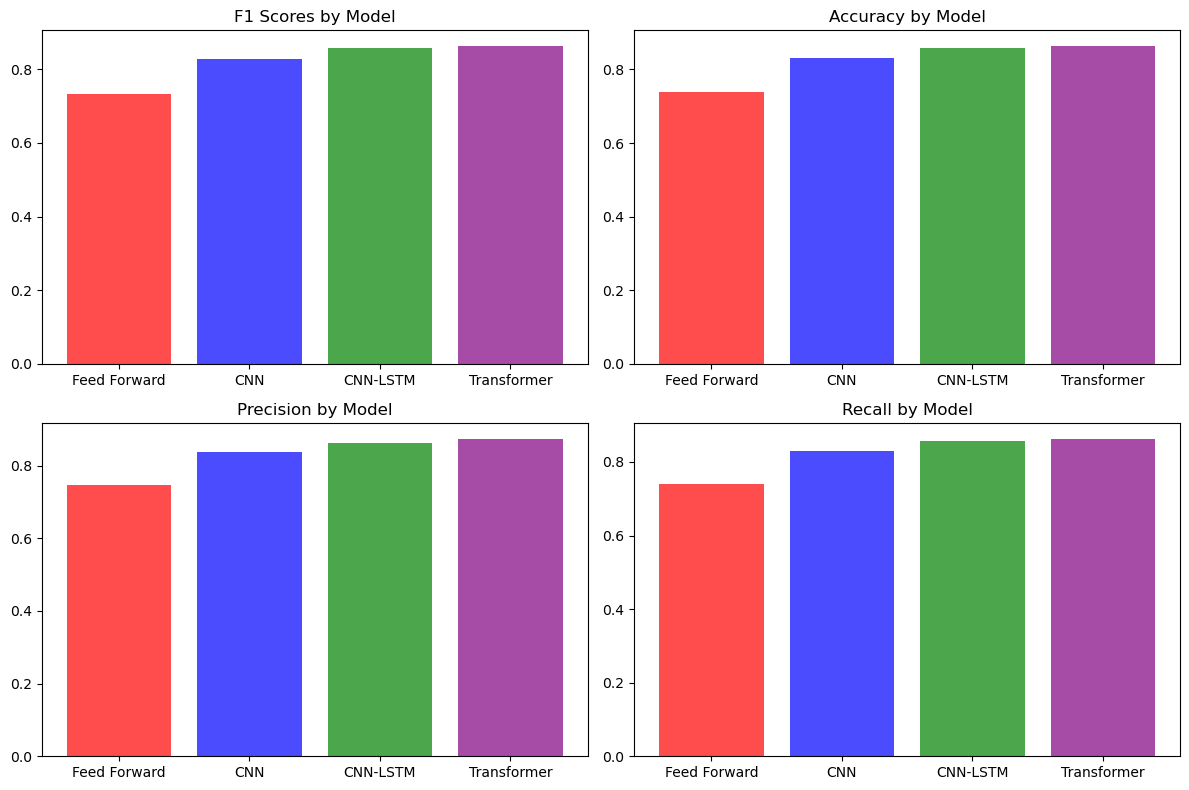

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

models = ['Feed Forward', 'CNN', 'CNN-LSTM', 'Transformer']
colors = ['red', 'blue', 'green', 'purple']


# Plot bar graphs
axes[0, 0].bar(models, f1_list, color=colors, alpha=0.7)
axes[0, 0].set_title("F1 Scores by Model")

axes[0, 1].bar(models, acc_list, color=colors, alpha=0.7)
axes[0, 1].set_title("Accuracy by Model")

axes[1, 0].bar(models, prec_list, color=colors, alpha=0.7)
axes[1, 0].set_title("Precision by Model")

axes[1, 1].bar(models, recall_list, color=colors, alpha=0.7)
axes[1, 1].set_title("Recall by Model")



# Adjust layout to avoid overlap
plt.tight_layout()

# Show the figure
plt.show()
